In [24]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, glob
import gzip
import random
import tqdm
import json
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

from IPython import display
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime
     

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set()

from scipy.stats import probplot, boxcox
from scipy.special import inv_boxcox
import pylab

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
df = pd.read_csv('apartments_for_rent_classified_10K.csv', sep = ';', encoding = 'cp1252')
df.head().T

,0,1,2,3,4
id,5668626895,5664597177,5668626833,5659918074,5668626759
category,housing/rent/apartment,housing/rent/apartment,housing/rent/apartment,housing/rent/apartment,housing/rent/apartment
title,"Studio apartment 2nd St NE, Uhland Terrace NE,...",Studio apartment 814 Schutte Road,"Studio apartment N Scott St, 14th St N, Arling...",Studio apartment 1717 12th Ave,"Studio apartment Washington Blvd, N Cleveland ..."
body,"This unit is located at second St NE, Uhland T...","This unit is located at 814 Schutte Road, Evan...","This unit is located at N Scott St, 14th St N,...","This unit is located at 1717 12th Ave, Seattle...","This unit is located at Washington Blvd, N Cle..."
amenities,NaN,NaN,NaN,NaN,NaN
bathrooms,NaN,NaN,1.0,1.0,NaN
bedrooms,0.0,1.0,0.0,0.0,0.0
currency,USD,USD,USD,USD,USD
fee,No,No,No,No,No
has_photo,Thumbnail,Thumbnail,Thumbnail,Thumbnail,Thumbnail


In [46]:

df.isnull().sum()

id                  0
category            0
title               0
body                0
amenities        3466
bathrooms           0
bedrooms            0
currency            0
fee                 0
has_photo           0
pets_allowed     4108
price               0
price_display       0
price_type          0
square_feet         0
address          3305
cityname            0
state               0
latitude            0
longitude           0
source              0
time                0
dtype: int64

In [45]:
df = df.dropna(subset = ['bedrooms', 'bathrooms', 'cityname', 'state', 'latitude', 'longitude'])

In [ ]:
#if amenities is not NaN, count the number of colon and add 1 to get the number of amenities and show the first 20 rows
df['amenities'] = df['amenities'].fillna('')
df['amenities_count'] = df['amenities'].apply(lambda x: x.count(','))
df['amenities_count'].head(20)




2     1
3     1
5     5
8     1
14    1
15    8
16    8
17    1
18    1
19    1
20    1
21    7
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
Name: amenities_count, dtype: int64

In [28]:
df.loc[df['cityname'].isna() | df['state'].isna(), ['longitude', 'latitude']].value_counts()

longitude  latitude
-98.5576   39.8163     66
-82.1971   28.4590      1
Name: count, dtype: int64

In [29]:
print(df.amenities.value_counts()[:15])
print('-' * 50)
print(df.amenities.value_counts()[-10:])

amenities
Parking                                                          229
Dishwasher,Refrigerator                                          225
Pool                                                             171
Dishwasher,Parking,Pool                                          149
Dishwasher                                                       147
Dishwasher,Parking,Refrigerator                                   94
Parking,Pool                                                      93
Refrigerator                                                      85
Parking,Storage                                                   68
Parking,Refrigerator                                              67
Gym,Parking,Pool                                                  59
Dishwasher,Parking,Pool,Refrigerator                              56
Gym,Pool                                                          56
Dishwasher,Elevator,Internet Access,Parking,Pool,Refrigerator     41
Dishwasher,Garbage Dispo

In [30]:

df.isna().sum()

id                  0
category            0
title               0
body                0
amenities        3549
bathrooms          34
bedrooms            7
currency            0
fee                 0
has_photo           0
pets_allowed     4163
price               0
price_display       0
price_type          0
square_feet         0
address          3327
cityname           77
state              77
latitude           10
longitude          10
source              0
time                0
dtype: int64

In [31]:

df = df.drop(['address'], axis=1)
df.loc[df['pets_allowed'].isna(), 'pets_allowed'] = 'None'
     

## remove null rows for bathrooms, bedrooms, price, price_display, latitude, longitude
print(f"Removing {df.loc[df['bathrooms'].isna() | df['bedrooms'].isna() | df['price'].isna() | df['price_display'].isna() | df['latitude'].isna() | df['longitude'].isna(), 'id'].shape} entries with null values.")
df = df.dropna(subset=['bathrooms', 'bedrooms', 'price', 'price_display', 'latitude', 'longitude'])
df.isna().sum()

Removing (50,) entries with null values.


id                  0
category            0
title               0
body                0
amenities        3508
bathrooms           0
bedrooms            0
currency            0
fee                 0
has_photo           0
pets_allowed        0
price               0
price_display       0
price_type          0
square_feet         0
cityname           67
state              67
latitude            0
longitude           0
source              0
time                0
dtype: int64

In [32]:
df.loc[((df['cityname'].isna()) | (df['state'].isna())) & (df['longitude']==-98.5576), 'cityname'] = 'Lebanon'
df.loc[((df['cityname'].isna()) | (df['state'].isna())) & (df['longitude']==-98.5576), 'state'] = 'KS'
df.loc[((df['cityname'].isna()) | (df['state'].isna())) & (df['longitude']==-75.9597), 'cityname'] = 'Cape Charles'
df.loc[((df['cityname'].isna()) | (df['state'].isna())) & (df['longitude']==-75.9597), 'state'] = 'VA'
df.loc[((df['cityname'].isna()) | (df['state'].isna())) & (df['longitude']==-92.2006), 'cityname'] = 'Waynesville'
df.loc[((df['cityname'].isna()) | (df['state'].isna())) & (df['longitude']==-92.2006), 'state'] = 'MO'

df = df.dropna(subset=['cityname', 'state'])
df.loc[:, ['cityname', 'state']].isna().sum()

cityname    0
state       0
dtype: int64

In [33]:


# First, fill NAs with 'basic'
df['amenities'] = df['amenities'].fillna(value='basic')

# Define luxury amenities
luxury_amenities = [
    "Gym", "Pool", "Clubhouse", "Hot Tub",
    "Doorman", "Gated", "View",
    "Tennis", "Elevator", "Fireplace",
    "Basketball Court", "Basketball", "Playground"
]

# Create a pattern for luxury amenities
luxury_pattern = '|'.join(luxury_amenities)

# Classify amenities as 'luxury' or 'basic'
df['amenities'] = ['luxury' if any(amenity in x for amenity in luxury_amenities) else 'basic' for x in df['amenities']]

# Check the counts of 'luxury' and 'basic'
print(df['amenities'].value_counts())


amenities
basic     5593
luxury    4356
Name: count, dtype: int64


In [34]:
df = df.drop(['title', 'body', 'id'], axis=1)
df = df.drop(['category', 'currency', 'fee'], axis=1)
df = df.drop(['price_type'], axis=1)
df = df.drop(['price_display'],axis=1)

In [35]:
numer = ['bathrooms', 'bedrooms', 'price', 'square_feet', 'time']
df.loc[:, numer].describe()

,bathrooms,bedrooms,price,square_feet,time
count,9949.000000,9949.000000,9949.000000,9949.000000,9.949000e+03
mean,1.380591,1.747512,1487.647502,943.285456,1.574881e+09
std,0.615332,0.941587,1077.387033,526.440776,3.767721e+06
min,1.000000,0.000000,200.000000,107.000000,1.568744e+09
25%,1.000000,1.000000,950.000000,650.000000,1.568781e+09
50%,1.000000,2.000000,1275.000000,803.000000,1.577358e+09
75%,2.000000,2.000000,1695.000000,1100.000000,1.577359e+09
max,8.500000,9.000000,52500.000000,11318.000000,1.577362e+09


In [36]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
     

fig = make_subplots(rows=2, cols=2, subplot_titles=[f'Distribution of {feature}' for feature in numer[:4]])
positions = [(1, 1), (1, 2), (2, 1), (2, 2)]

for feature, pos in zip(numer[:4], positions):
    box_data = px.box(df, x=feature)
    fig.add_trace(
        go.Box(y=df[feature], name=f'{feature}'),
        row=pos[0], col=pos[1])

fig.update_layout(title_text="Numerical Variables Distribution - Box Plots", height=800, width=1000)
fig.show()

In [37]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Sample DataFrame
# Assuming 'df' contains your DataFrame with numerical variables
numer = df.select_dtypes(include='number').columns.tolist()

# Create subplots with subplot titles
fig = make_subplots(rows=2, cols=2, subplot_titles=[f'Distribution of {feature}' for feature in numer[:4]])

# Positions for the subplots
positions = [(1, 1), (1, 2), (2, 1), (2, 2)]

# Custom colors for the box plots
box_colors = ['#FF5733', '#33FF57', '#3399FF', '#FF33E9']

# Loop through numerical features and positions
for i, (feature, pos) in enumerate(zip(numer[:4], positions)):
    # Create a box plot using Plotly Express
    box_data = px.box(df, x=feature)

    # Extract box plot traces and update colors
    box_trace = box_data['data'][0]
    box_trace.update(marker_color=box_colors[i])  # Update marker color

    # Add the box trace to the subplot
    fig.add_trace(
        box_trace,
        row=pos[0], col=pos[1])

# Update layout
fig.update_layout(title_text="Numerical Variables Distribution - Box Plots", height=800, width=1000)

# Show the figure
fig.show()

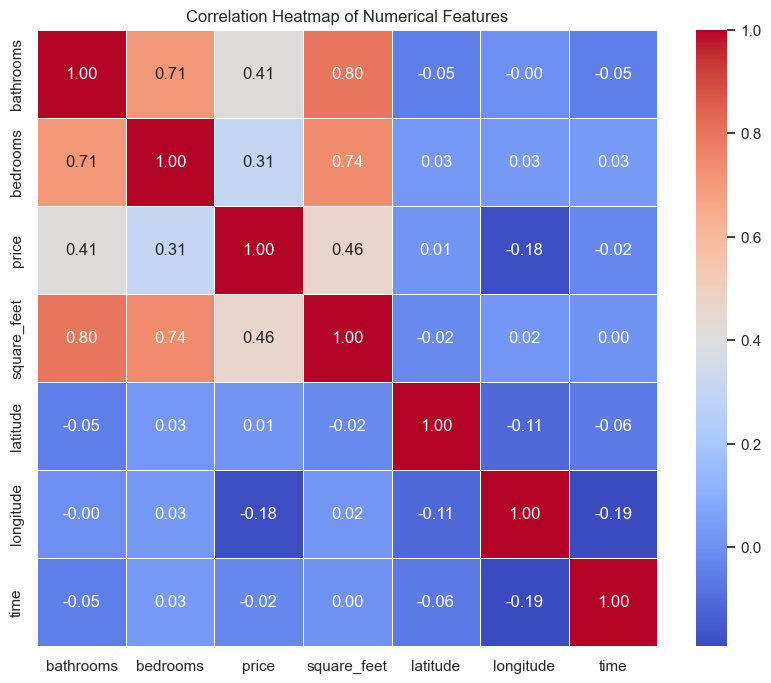

In [38]:

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=2, subplot_titles=[f'Distribution of {feature}' for feature in numer[:4]])
positions = [(1, 1), (1, 2), (2, 1), (2, 2)]

for feature, pos in zip(numer[:4], positions):
    violin_data = px.violin(df, y=feature)
    fig.add_trace(
        go.Violin(y=df[feature], name=f'{feature}'),
        row=pos[0], col=pos[1])

fig.update_layout(title_text="Numerical Variables Distribution - Violin Plots", height=800, width=1000)
fig.show()

     

import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
corr_matrix = numerical_columns.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

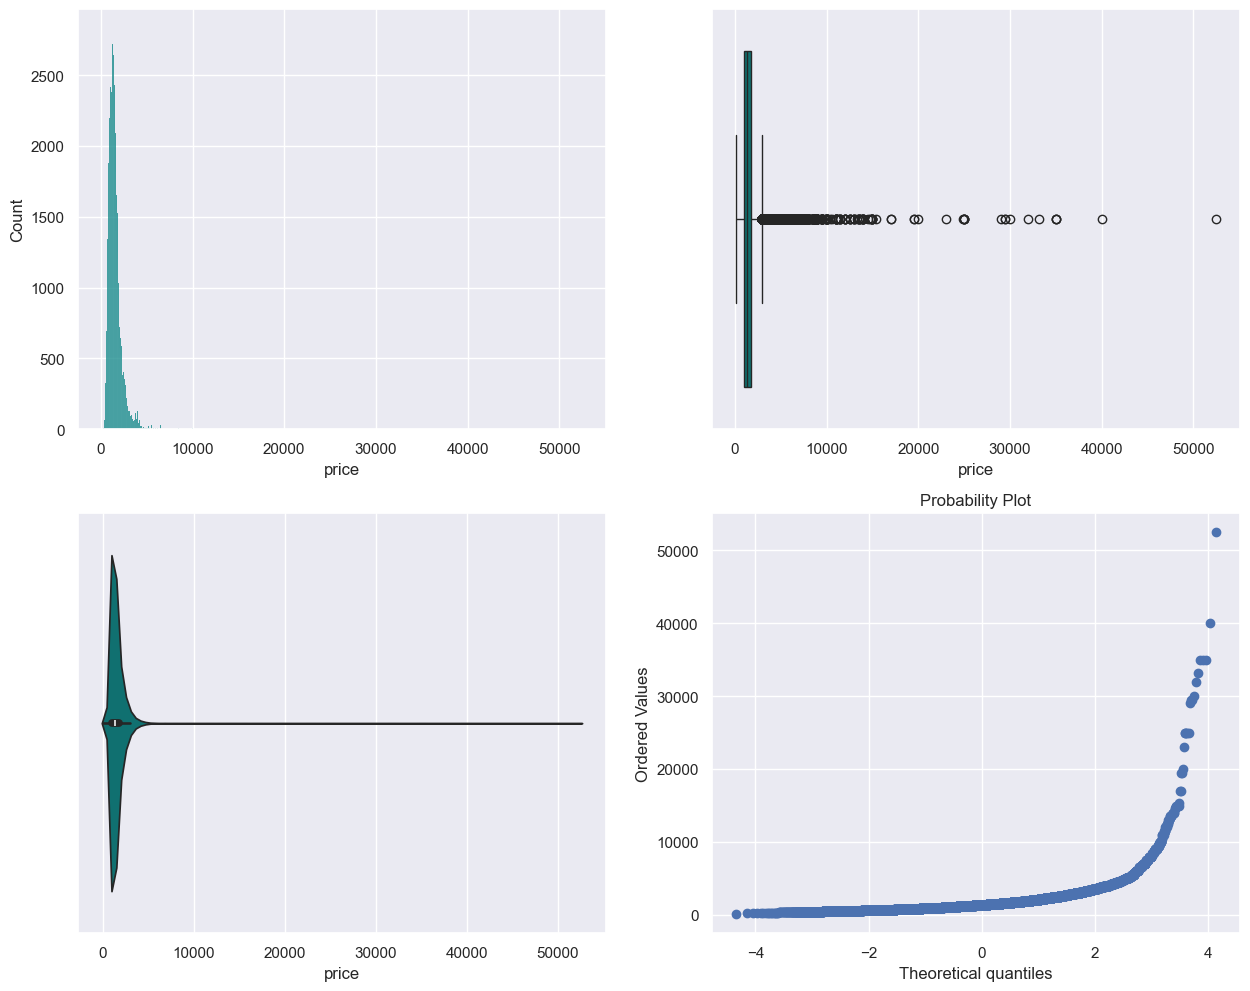

In [39]:
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
ax1 = sns.histplot(x = data['price'], color='teal', ax= ax[0, 0])
ax2 = sns.boxplot(x = data['price'], ax= ax[0, 1], color= 'teal')
ax3 = sns.violinplot(x = data['price'], ax= ax[1, 0], color= 'teal')
ax4 = probplot(data['price'], plot=pylab)
pylab.show()